# Discrete hedging experiment for a European Call option under the Heston model

> TODO: Add a description to the experiment

> Under the Heston but we are using the Black-Scholes delta for hedging

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

from jax import vmap, grad, jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.experimental.bs_iv import IV_brent
import py_vollib_vectorized

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.04
mean = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

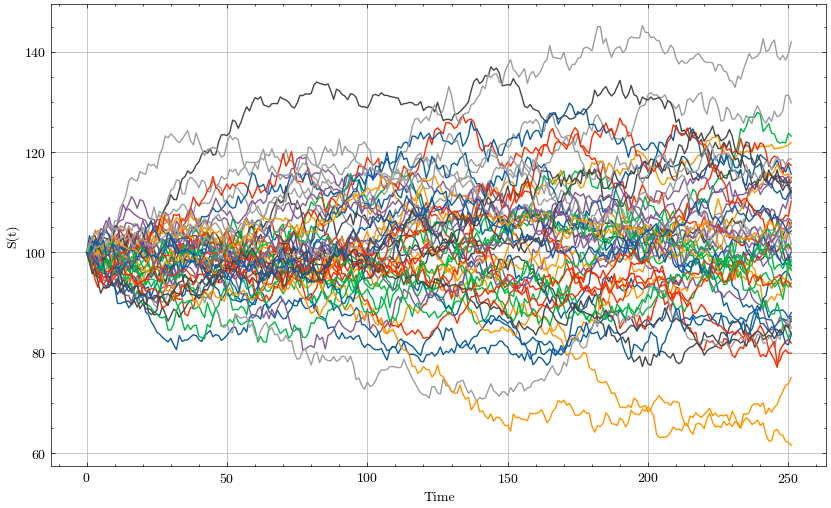

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :50])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [7]:
discount_rate = 0.0
dividends = 0.0

## Hedging experiment without transaction costs

In [8]:
ticksize = 0.00
K = 100
maturity = 1.0
N = 252
n_sim = 100

v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_delta_call = vmap(v_fourier_delta_call, in_axes=(None, None, None, 0, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_inv_call = vmap(v_fourier_inv_call, in_axes=(None, None, None, 0, None, None, None, None, None))

In [9]:
def heston_vega(s0, K, T, v, mu, theta, sigma, kappa, rho):
    return grad(fourier_inv_call, argnums=3)(s0, K, T, v, mu, theta, sigma, kappa, rho)

_v_heston_vega = vmap(heston_vega, in_axes=(0, None, None, None, None, None, None, None, None))
v_heston_vega = vmap(_v_heston_vega, in_axes=(None, None, None, 0, None, None, None, None, None))

In [10]:
def get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    deltas = [v_v_fourier_delta_call(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    deltas_ = [v_v_fourier_delta_call(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(deltas + deltas_)

def get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    vegas = [v_heston_vega(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    vegas_ = [v_heston_vega(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(vegas + vegas_)

def get_heston_hedging_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    vegas = get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)
    deltas = get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)

    return deltas + (rho * sigma / stock_paths) * vegas


In [11]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [12]:
def hedge_experiment_loop(stock_paths, var_process, K, mu, sigma, maturity, N, ticksize=0.00):
    dt = maturity / N
    deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, mu, theta, sigma, kappa, rho, N)
    cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], mu, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0]]
    vs = [cs[0]]

    for i in range(1, N):
        ddelta = deltas[i] - deltas[i - 1]
        transaction_costs = get_transaction_costs(ticksize, ddelta)

        vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
        b.append(vs[i] - deltas[i] * stock_paths[i] - transaction_costs)
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

    return jnp.nanmean(hedge_error[-1]), jnp.nanstd(hedge_error[-1]) / jnp.asarray(cs)[0, 0]

### Experiments

In [13]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [14]:
def update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike'].append(K)
    results['Sigma'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

In [15]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.0204002782702446
The normalized std of the hedge error is: 0.11267805099487305


Weekly rebalancing $n=52$

In [16]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [17]:
var_process.shape

(52, 100)

In [18]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.0245901457965374
The normalized std of the hedge error is: 0.14247103035449982


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [19]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [20]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.052812229841947556
The normalized std of the hedge error is: 0.02051299624145031


Weekly rebalancing $n=52$

In [21]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [22]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.05278638005256653
The normalized std of the hedge error is: 0.03264165297150612


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [23]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [24]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.02393539994955063
The normalized std of the hedge error is: 0.062291521579027176


Weekly rebalancing $n=52$

In [25]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [26]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.09469927847385406
The normalized std of the hedge error is: 0.06990029662847519


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [27]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [28]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.030706070363521576
The normalized std of the hedge error is: 0.351990669965744


Weekly rebalancing $n=52$

In [29]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [30]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.03132832422852516
The normalized std of the hedge error is: 0.3118216395378113


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [31]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [32]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.07992818206548691
The normalized std of the hedge error is: 0.5246503949165344


Weekly rebalancing $n=52$

In [33]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [34]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.0678737461566925
The normalized std of the hedge error is: 0.4923644959926605


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [35]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [36]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.06251278519630432
The normalized std of the hedge error is: 0.19847486913204193


Weekly rebalancing $n=104$

In [37]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [38]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.3004119396209717
The normalized std of the hedge error is: 0.22241996228694916


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [39]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [40]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [41]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [42]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [43]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [44]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [45]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [46]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [47]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.020400278,0.11267805
1,100,0.1,1.0,52,0.024590146,0.14247103
2,80,0.1,1.0,252,-0.05281223,0.020512996
3,80,0.1,1.0,52,0.05278638,0.032641653
4,90,0.1,1.0,52,-0.0239354,0.06229152
5,90,0.1,1.0,52,0.09469928,0.0699003
6,110,0.1,1.0,52,-0.03070607,0.35199067
7,110,0.1,1.0,52,-0.031328324,0.31182164
8,120,0.1,1.0,52,0.07992818,0.5246504
9,120,0.1,1.0,52,-0.067873746,0.4923645


In [48]:
res_df.to_csv('./results/heston_delta_zero.csv')

### Hedging experiments with low transcation costs

### Experiments

In [49]:
ticksize = 0.01
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [50]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [51]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.026731843128800392
The normalized std of the hedge error is: 0.08344985544681549


Weekly rebalancing $n=52$

In [52]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [53]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.004967994522303343
The normalized std of the hedge error is: 0.17445409297943115


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [54]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [55]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.0003458643041085452
The normalized std of the hedge error is: 0.018710482865571976


Weekly rebalancing $n=52$

In [56]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [57]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.02073035016655922
The normalized std of the hedge error is: 0.029793502762913704


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [58]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [59]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.16174057126045227
The normalized std of the hedge error is: 0.08106845617294312


Weekly rebalancing $n=52$

In [60]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [61]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.10448168963193893
The normalized std of the hedge error is: 0.073769211769104


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [62]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [63]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.04166979715228081
The normalized std of the hedge error is: 0.3170228898525238


Weekly rebalancing $n=52$

In [64]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [65]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.08559700846672058
The normalized std of the hedge error is: 0.25567078590393066


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [66]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [67]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.02648763731122017
The normalized std of the hedge error is: 0.47213101387023926


Weekly rebalancing $n=52$

In [68]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [69]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.06673191487789154
The normalized std of the hedge error is: 0.5219640731811523


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [70]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [71]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.24128390848636627
The normalized std of the hedge error is: 0.19944541156291962


Weekly rebalancing $n=104$

In [72]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [73]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.015929432585835457
The normalized std of the hedge error is: 0.22482123970985413


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [74]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [75]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [76]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [77]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [78]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [79]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [80]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [81]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [82]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.026731843,0.083449855
1,100,0.1,1.0,52,0.0049679945,0.1744541
2,80,0.1,1.0,252,-0.0003458643,0.018710483
3,80,0.1,1.0,52,-0.02073035,0.029793503
4,90,0.1,1.0,52,-0.16174057,0.081068456
5,90,0.1,1.0,52,0.10448169,0.07376921
6,110,0.1,1.0,52,-0.041669797,0.3170229
7,110,0.1,1.0,52,-0.08559701,0.2556708
8,120,0.1,1.0,52,-0.026487637,0.472131
9,120,0.1,1.0,52,0.066731915,0.5219641


In [83]:
res_df.to_csv('./results/heston_delta_low.csv')

### Hedging experiments with high transcation costs

### Experiments

In [84]:
ticksize = 0.05
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [85]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [86]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.2647838890552521
The normalized std of the hedge error is: 0.10124412924051285


Weekly rebalancing $n=52$

In [87]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [88]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.0611206516623497
The normalized std of the hedge error is: 0.13129793107509613


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [89]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [90]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.06397795677185059
The normalized std of the hedge error is: 0.017052635550498962


Weekly rebalancing $n=52$

In [91]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [92]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.00514328945428133
The normalized std of the hedge error is: 0.02673834003508091


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [93]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [94]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.2772272229194641
The normalized std of the hedge error is: 0.07731474190950394


Weekly rebalancing $n=52$

In [95]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [96]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.15728576481342316
The normalized std of the hedge error is: 0.06266964226961136


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [97]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [98]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.14674320816993713
The normalized std of the hedge error is: 0.2690168023109436


Weekly rebalancing $n=52$

In [99]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [100]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.16643816232681274
The normalized std of the hedge error is: 0.23939788341522217


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [101]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [102]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.08024781942367554
The normalized std of the hedge error is: 0.4922246038913727


Weekly rebalancing $n=52$

In [103]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [104]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.04105575010180473
The normalized std of the hedge error is: 0.44857820868492126


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [105]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [106]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.3637424409389496
The normalized std of the hedge error is: 0.20466354489326477


Weekly rebalancing $n=104$

In [107]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [108]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.0850677490234375
The normalized std of the hedge error is: 0.20421616733074188


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [109]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [110]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [111]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [112]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [113]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [114]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [115]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [116]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [117]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.2647839,0.10124413
1,100,0.1,1.0,52,0.06112065,0.13129793
2,80,0.1,1.0,252,-0.06397796,0.017052636
3,80,0.1,1.0,52,0.0051432895,0.02673834
4,90,0.1,1.0,52,-0.27722722,0.07731474
5,90,0.1,1.0,52,0.15728576,0.06266964
6,110,0.1,1.0,52,-0.14674321,0.2690168
7,110,0.1,1.0,52,-0.16643816,0.23939788
8,120,0.1,1.0,52,-0.08024782,0.4922246
9,120,0.1,1.0,52,-0.04105575,0.4485782


In [118]:
res_df.to_csv('./results/heston_delta_high.csv')